In [1]:
import torch
import numpy as np
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import pickle
import yaml
import os
import cv2

In [2]:
task = ["openable", "cuttable", "pourable", "containable", "supportable", "holdable"]
cmap = mcolors.ListedColormap(['black', 'red', 'white'])
norm = mcolors.Normalize(0, 255)

def plot(input=None, weak_target=None, target=None, output=None, mask=None):
    if input is not None:
        plt.figure(figsize=(6, 6))
        plt.imshow(input)
        plt.title("Input", fontsize=20)
        plt.show()

    if weak_target is not None:
        plt.figure(figsize=(30, 4))
        num_classes = len(weak_target)
        for i in range(num_classes):
            plt.subplot(1, num_classes, i+1)
            img = np.array(weak_target[i])
            img[img==255] = 128
            img[img==1] = 255
            plt.imshow(img, cmap=cmap, norm=norm)
            plt.title("Weak: " + task[i], fontsize=20)
        plt.show()

    if target is not None:
        plt.figure(figsize=(30, 4))
        num_classes = len(target)
        for i in range(num_classes):
            plt.subplot(1, num_classes, i+1)
            img = np.array(target[i])
            img[img==255] = 128
            img[img==1] = 255
            plt.imshow(img, cmap=cmap, norm=norm)
            plt.title("Target: " + task[i], fontsize=20)
        plt.show()
    
    if output is not None:
        plt.figure(figsize=(30, 4))
        num_classes = len(output)
        for i in range(num_classes):
            plt.subplot(1, num_classes, i+1)
            img = np.array(output[i])
            img[img==1] = 255
            plt.imshow(img, cmap=cmap, norm=norm)
            plt.title("Output: " + task[i], fontsize=20)
        plt.show()

    if mask is not None:
        plt.figure(figsize=(6, 6))
        img = np.array(mask)
        img[img==1] = 255
        plt.imshow(img, cmap=cmap, norm=norm)
        plt.title("Mask", fontsize=20)
        plt.show()

In [3]:
def image_draw(image, keypoint):
    new_image = image.copy()
    draw = ImageDraw.Draw(new_image)
    stroke_width = 10
    for _, joints in keypoint:
        if len(joints) > 1:
            draw.line(np.array(joints).flatten(), 1, 10, joint="curve")
        for i in range(len(joints)):
            draw.ellipse(
                (
                    joints[i][0] - stroke_width / 2,
                    joints[i][1] - stroke_width / 2,
                    joints[i][0] + stroke_width / 2,
                    joints[i][1] + stroke_width / 2,
                ),
                1,
            )

    return new_image

In [4]:
from model import CerberusAffordanceModel
model = CerberusAffordanceModel(len(task))
model.eval()
print(task)

['openable', 'cuttable', 'pourable', 'containable', 'supportable', 'holdable']


In [5]:
resume_time = "20220720_073749"
resume_level = "model_best"
resume_path = f"output/train/{resume_time}/model/{resume_level}.pth"
model.load_state_dict(
    {
        k.replace("module.", ""): v
        for k, v in torch.load(resume_path)["state_dict"].items()
    }
)

<All keys matched successfully>

In [6]:
import transform as TF

mean = [132.477589209075859, 106.320224720657322, 111.570479922402896]
std = [67.450430198090885, 70.234843307855243, 72.198069533801629]

tf1 = TF.Compose(
    [
        TF.ConvertPointLabel(ignore_index=255, stroke_width=20),
        TF.RandomScaledTiltedWarpedPIL(
            random_crop_size=(321, 321),
            random_shrink_min=0.5,
            random_shrink_max=2.0,
            random_tilt_max_deg=10,
            random_wiggle_max_ratio=0,
            random_horizon_reflect=True,
            ignore_index=255,
            center_offset_instead_of_random=False,
        ),
    ]
)

tf2 = TF.Compose([TF.PILToTensor(), TF.ImageNormalizeTensor(mean=mean, std=std)])



In [7]:
keypoint_path = "../dataset/cad120/object/train_affordance_keypoint.yaml"

with open(keypoint_path, "r") as fb:
    keypoint_dict = yaml.safe_load(fb)

In [8]:
file_name = "10017_1" # train: 10017_1 val: 10064_1
input_path = f"../dataset/cad120/object/affordance/images/{file_name}.png"
target_path = f"../dataset/cad120/object/affordance/labels/{file_name}.pkl"

data = dict()

data["file_name"] = os.path.basename(input_path).split(".")[0]

data["image"] = Image.open(input_path)

with open(target_path, "rb") as fb:
    dense_label = pickle.load(fb)
    data["dense_label"] = [Image.fromarray(dense_label[:, :, i]) for i in range(dense_label.shape[2])]

data["point_label"] = keypoint_dict[data["file_name"]]

data["validity"] = Image.new("L", data["image"].size, color=1)

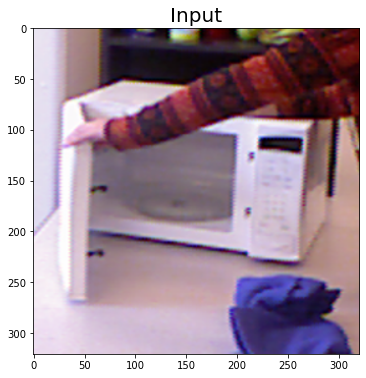

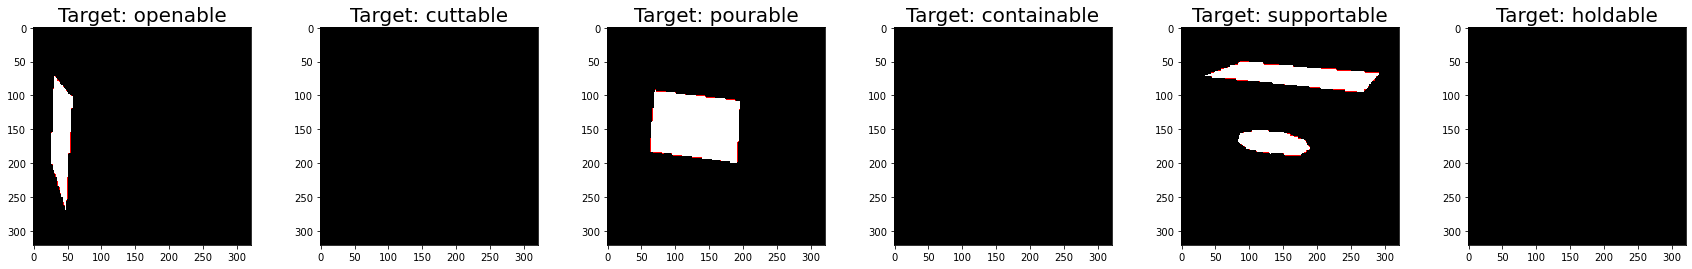

In [9]:
plot(input=data["image"], target=data["dense_label"])

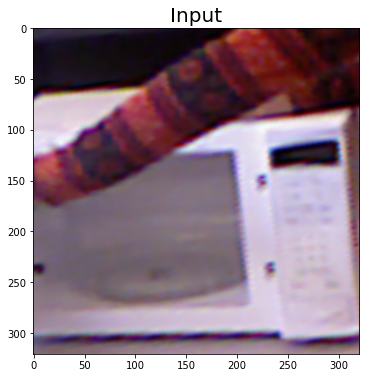

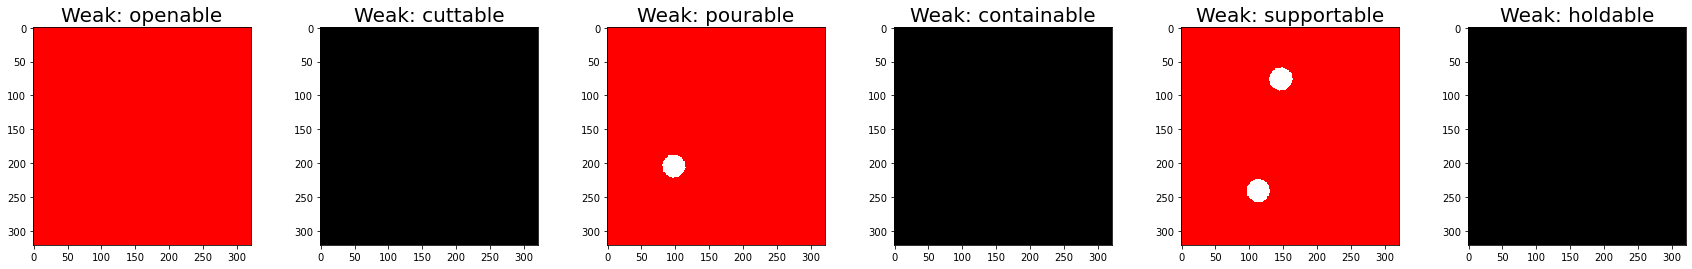

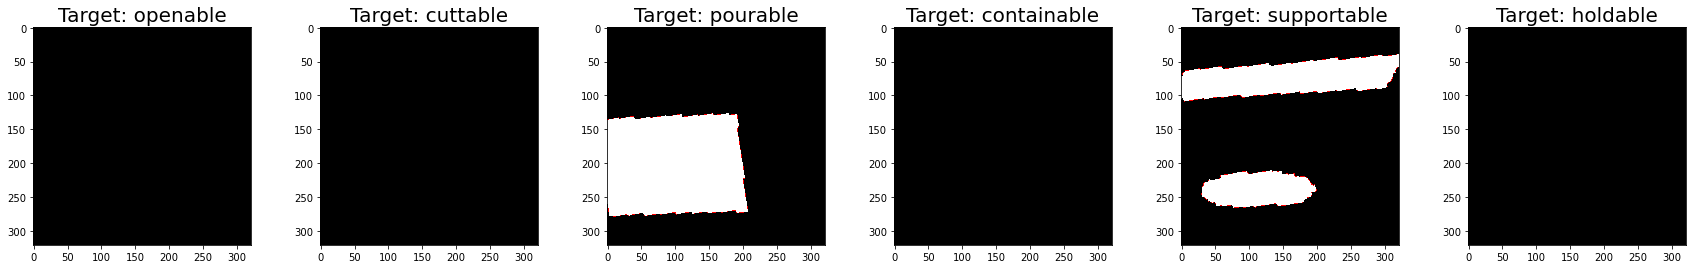

In [10]:
new_data = tf1(data.copy())
plot(input=new_data["image"], weak_target=new_data["weak_label"], target=new_data["dense_label"])

In [44]:
new_new_data = tf2(new_data.copy())

with torch.no_grad():
    output = model(new_new_data["image"].unsqueeze(0))

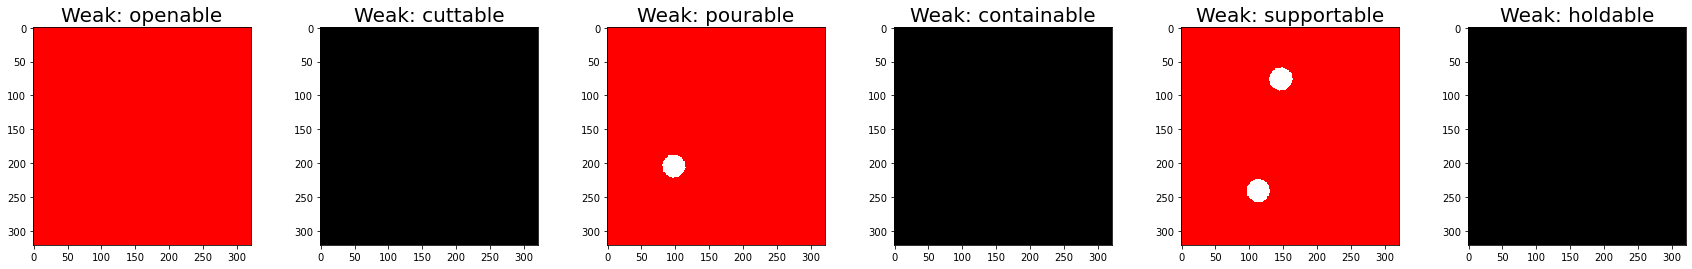

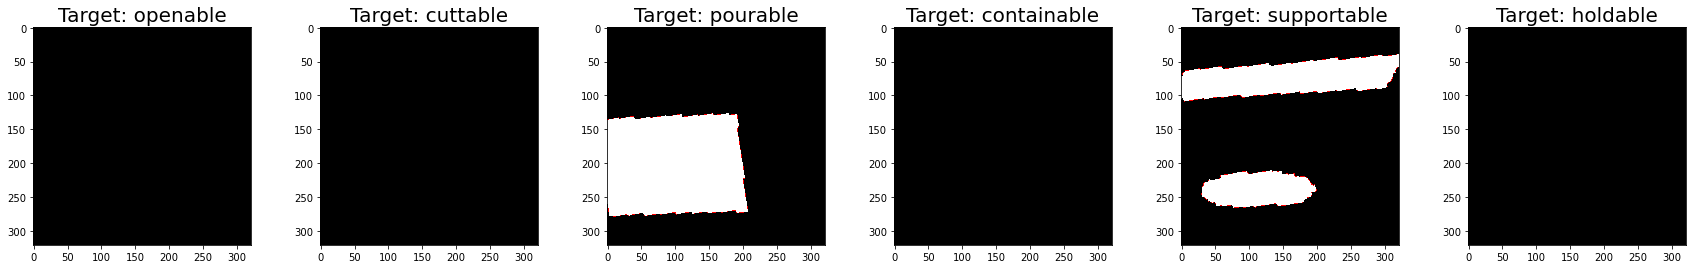

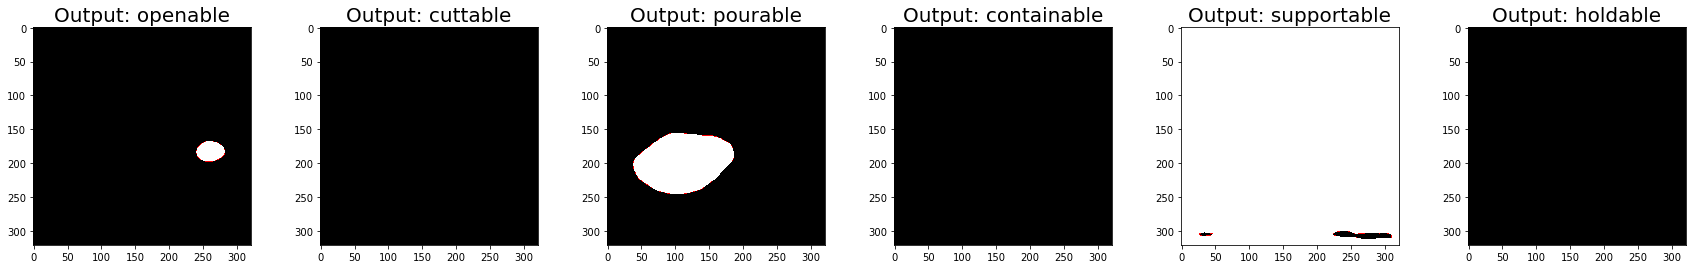

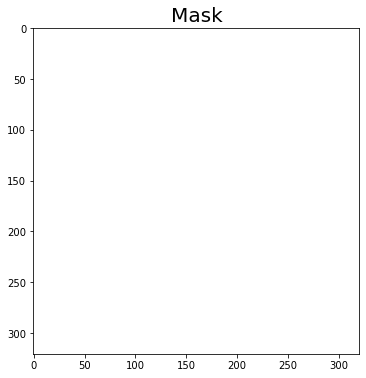

In [45]:
validity = new_new_data["validity"].squeeze(0)
pred = [output[i].argmax(1).squeeze(0) * validity for i in range(len(task))]
# pred = [(torch.sigmoid(output[i]) > 0.5).int().squeeze(0).squeeze(0) * validity for i in range(len(task))]

image_masked = image_draw(new_data["image"], new_data["point_label"])
plot(weak_target=new_new_data["weak_label"], target=new_new_data["dense_label"], output=pred, mask=validity)

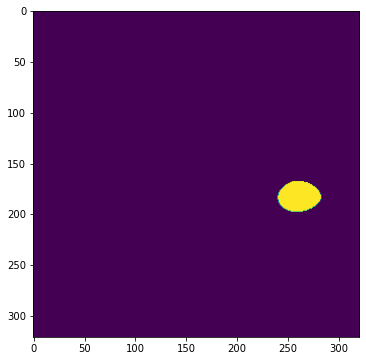

In [99]:
import pydensecrf.densecrf as dcrf

def dense_crf(img, probs, mode):
    n_labels = probs.shape[0]
    d = dcrf.DenseCRF2D(img.shape[1], img.shape[0], n_labels)
    
    if mode == "softmax":
        U = -np.log(np.clip(probs, 1e-5, 1.0)).reshape(n_labels, -1)
    elif mode == "sigmoid":
        U = -np.log(np.concatenate([1-probs, probs], axis=0)).reshape(2, -1)
    elif mode == "label":
        probs = probs.flatten()
        gt_prob = 0.8
        n_energy = -np.log(1-gt_prob)
        p_energy = -np.log(gt_prob)

        U = np.full((n_labels, len(probs)), n_energy, dtype='float32')
        U[probs, np.arange(U.shape[1])] = p_energy

    d.setUnaryEnergy(U)

    d.addPairwiseGaussian(sxy=5, compat=3, kernel=dcrf.DIAG_KERNEL,
                          normalization=dcrf.NORMALIZE_SYMMETRIC)

    d.addPairwiseBilateral(sxy=60, srgb=10, rgbim=img,
                           compat=10,
                           kernel=dcrf.DIAG_KERNEL,
                           normalization=dcrf.NORMALIZE_SYMMETRIC)
    
    Q = d.inference(5)
    Q = np.argmax(Q, axis=0).reshape((img.shape[0], img.shape[1]))
    return Q

Q = dense_crf(np.array(new_data["image"]), output[0].argmax(1).squeeze(0).numpy(), mode="label")

plt.figure(figsize=(6, 6))
plt.imshow(Q)
plt.show()